<a href="https://colab.research.google.com/github/devpatelio/dr.cnn/blob/main/TransferLearningCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainer_names_csv = pd.read_csv('/content/drive/MyDrive/pyTorch/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')
n = len(trainer_names_csv)
# data_labels = pd.DataFrame(data = trainer_names_csv)
img_names = trainer_names_csv.iloc[:n, 0]
label = trainer_names_csv.iloc[:n, 1]

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch

class DRDataset(Dataset):
    def __init__ (self, csv_file, root_dir, transform=None):
        """
        csv_file = labels
        root_dir = images
        
        """
        
        self.train_data_csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.train_data_csv)

    def __getitem__ (self, idx): 
        name = self.train_data_csv.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, name +'.png') ##fix logic
        image = Image.open(img_name).convert("RGB")
        y_labels = torch.tensor(float(self.train_data_csv.iloc[idx, 1:]))

        
        if self.transform is not None:
            image = self.transform(image)
        return (image, y_labels)

In [ ]:
from tqdm import tqdm
import random

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
   
])

num_epochs = 10
learning_rate = 0.01
train_CNN = True
batch_size = 10
shuffle = True
pin_memory = True
num_workers = 0



train_size = int(0.7 * n)
validation_size = n - train_size


# image_dataset = DRDataset(csv_file='/content/drive/MyDrive/pyTorch/diabetic-retinopathy-224x224-gaussian-filtered/train.csv', root_dir='/content/drive/MyDrive/pyTorch/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/')

dataset = DRDataset(csv_file='/content/drive/MyDrive/pyTorch/diabetic-retinopathy-224x224-gaussian-filtered/train.csv', root_dir='/content/drive/MyDrive/pyTorch/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/', 
                               transform=transform)

train_set, validation_set = torch.utils.data.random_split(dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)




dataiter = iter(train_loader)
image, label = dataiter.next()

# print(data[0].shape)
# print(data[1].shape)
# print(data[1])

print(image.shape)
print(label.shape)

torch.Size([10, 3, 224, 224])
torch.Size([10])


In [ ]:
import torchvision.models as models
from torch.autograd import Variable
import time


model_vgg = models.vgg16(pretrained=True)
for param in model_vgg.parameters():
    param.requires_grad = False
    
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    for i, data in enumerate(dataset, 0):
        inputs, labels = data
        inputs , labels = Variable(inputs),Variable(labels)
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


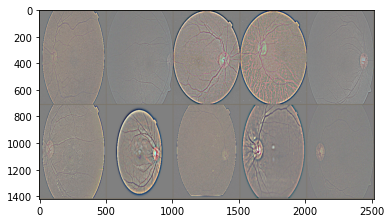

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import cv2

plt.ion()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


train_set, validation_set = torch.utils.data.random_split(dataset, [train_size, validation_size])
image_dataset = {'train': train_set, 'val': validation_set}
dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']} 
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val']}

device = torch.device("cpu")

def imshow(inp, title):
    imshow_mean = np.array(mean)
    imshow_std = np.array(std)
    inp = (inp.numpy().transpose((1, 2, 0))) * imshow_std + imshow_mean
    inp = np.clip(inp, 0, 1)
    inp = cv2.resize(inp, (2520, 1420))
    plt.imshow(inp)
    plt.pause(0.001)

dataiters = iter(dataloaders['train'])
images, labels = dataiters.next()

out = torchvision.utils.make_grid(images, 5) # represents no. of images per row displayed
imshow(out, title=f'{labels}')

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_models_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for session_type in ['train', 'val']:
            if session_type == 'train':
                model.train() 
            elif session_type == 'val': 
                model.eval()
        
            run_loss, run_corrects = 0.0, 0

            for inputs, labels in dataloaders[session_type]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.requires_grad(True, session_type == 'train'):
                    outputs = model(inputs)
                    tensor_pred, long_pred = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.type(torch.LongTensor))
                    if session_type == 'train':
                        loss.backward()
                        optimizer.step()

                run_loss =+ loss.item() * inputs.size(0)
                if preds == labels.data:
                  run_corrects += torch.sum(keepdim=True)
                else:
                  run_corrects += torch.sum(keepdim=False)
            if session_type == 'train':
                scheduler.step() ## changes the learning rate as per the gradient 

            epoch_loss = run_loss/dataset_sizes[session_type] #as a loss item
            epoch_acc = run_corrects.double()/dataset_sizes[session_type] #as a percent of total correct preds

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(session_type, epoch_loss, epoch_acc)) 
            print('{} Learning Rate {:.4f}'.format(session_type, optimizer.param_groups[0]['lr'])) ##returns change in learning rate over each epoch

            if session_type == 'val' and epoch_acc > best_acc: #during validation, rewrites best_accuracy with current epoch_accuracy
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #copies model and reruns next epoch with new model

    time_elapsed = time.time() - since 
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=20): 
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5) #output of layer is going to be 5, input is num_ftrs


#in the train_model function, we pre-established the dataset being used -> you can change that easily for new datasets if you wanted
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) #reduces lr by 0.1 ever 7 epochs


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch 0/24
----------
train Loss: 0.0002 Acc: 0.7226
val Loss: 0.0031 Acc: 0.7825

Epoch 1/24
----------
train Loss: 0.0001 Acc: 0.7905
val Loss: 0.0054 Acc: 0.7880

Epoch 2/24
----------
train Loss: 0.0015 Acc: 0.8416
val Loss: 0.0020 Acc: 0.7916

Epoch 3/24
----------
train Loss: 0.0002 Acc: 0.8896
val Loss: 0.0008 Acc: 0.7889

Epoch 4/24
----------
train Loss: 0.0003 Acc: 0.9356
val Loss: 0.0039 Acc: 0.7816

Epoch 5/24
----------
train Loss: 0.0016 Acc: 0.9446
val Loss: 0.0048 Acc: 0.8053

Epoch 6/24
----------
train Loss: 0.0000 Acc: 0.9661
val Loss: 0.0025 Acc: 0.8098

Epoch 7/24
----------
train Loss: 0.0002 Acc: 0.9836
val Loss: 0.0095 Acc: 0.8071

Epoch 8/24
----------
train Loss: 0.0002 Acc: 0.9887
val Loss: 0.0064 Acc: 0.8080

Epoch 9/24
----------
train Loss: 0.0000 Acc: 0.9887
val Loss: 0.0133 Acc: 0.8071

Epoch 10/24
----------
train Loss: 0.0000 Acc: 0.9887
val Loss: 0.0118 Acc: 0.7962

Epoch 11/24
----------
train Loss: 0.0000 Acc: 0.9879
val Loss: 0.0010 Acc: 0.7989

E

In [ ]:
model = models.resnet18(pretrained=True)
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []


save_output = SaveOutput()

hook_handles = []

for layer in model.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        handle = layer.register_forward_hook(save_output.__call__)
        hook_handles.append(handle)


image = Image.open('/content/drive/MyDrive/pyTorch/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/000c1434d8d7.png')


transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

out = model(X)

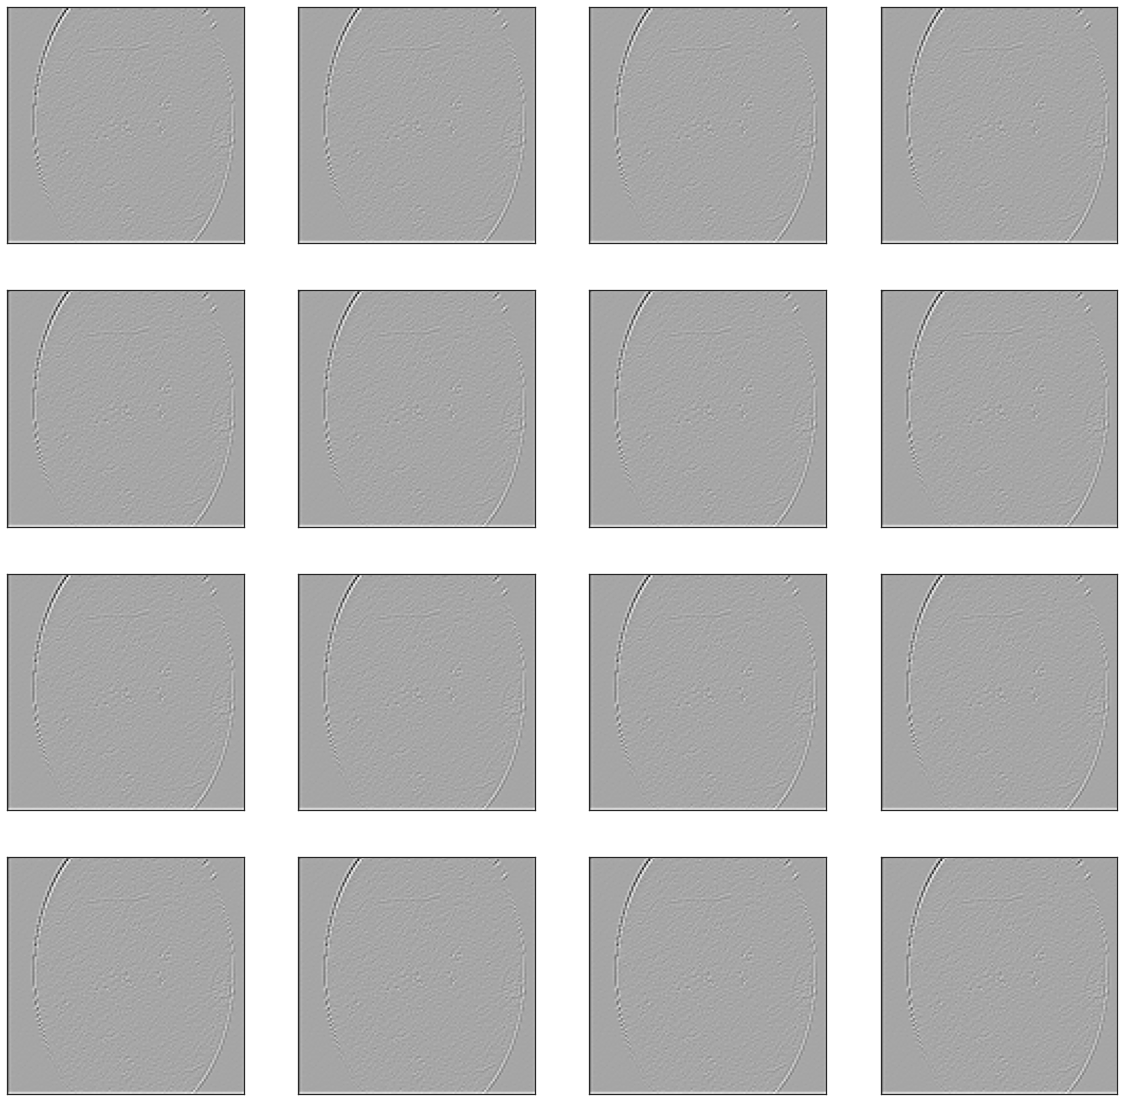

In [ ]:
np_image = save_output.outputs[0].detach().numpy()
with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 20), frameon=False)
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_image[0, idx])
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);